In [1]:
%reload_ext tensorboard
%load_ext autoreload

# Large Deformation Diffeomorphic Metric Mapping and PCA

In [2]:
import os
import time
import torch
import numpy as np
import pyvista as pv


from tqdm import tqdm
from geomloss import SamplesLoss
from joblib import dump, load
import pytorch_lightning as pl
from sklearn.decomposition import PCA
from pdmtut.datasets import SwissRoll
from pdmtut.core import GenerativeModel
from pytorch_lightning import loggers as pl_loggers
from regilib.core.invertible_modules.charts import PadProj
from regilib.core.dynamics.dynamical_state import DynamicalState
from torchcubicspline import natural_cubic_spline_coeffs, NaturalCubicSpline
from regilib.core.invertible_modules.bijective import ShootingLayer, PointCloudDeformationLayer

In [3]:
store_results = True
load_models = True

## Introduction

## Implementation

In [4]:
class LDDMMPCA(pl.LightningModule, GenerativeModel):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components

        self.base_distribution = torch.nn.parameter.Parameter(
            torch.stack(torch.meshgrid(
                torch.linspace(0, 1, steps=100),
                torch.zeros(1),
                torch.linspace(-1, +1, steps=100),
                indexing='xy'), -1).view(100*100, 3), 
            requires_grad=False)
        
        n_cps_x, n_cps_z = 20, 20
        self.shooting_layer = ShootingLayer(
            control_points = torch.stack(
                torch.meshgrid(
                    torch.linspace(0, 1, steps=n_cps_x),
                    torch.zeros(1),
                    torch.linspace(-1, +1, steps=n_cps_z),
                    indexing='xy'),
                -1).view(n_cps_x*n_cps_z, 3), sigma=4/20, default_n_steps=20, solver='rk4')
        
        self.warp = PointCloudDeformationLayer(default_n_steps=20, solver='rk4')
        
        self.loss = SamplesLoss(loss="sinkhorn", p=2, blur=1e-12, reach=0.1)

        self.momenta = torch.nn.parameter.Parameter(
            torch.empty(self.shooting_layer.control_points.shape)
        )
        #torch.nn.init.normal_(self.momenta)
        torch.nn.init.zeros_(self.momenta)
        self.chart = PadProj()
        
    def fit_model(self, X, X_val=None, path=None):
        start_time = time.time()

        if path is None:
            tb_logger = False
            checkpoint_callback=False
        else:
            tb_logger = pl_loggers.TensorBoardLogger(path, version=0)
            checkpoint_callback=True
            
        trainer = pl.Trainer(
            max_epochs=1000, gpus=1, logger=tb_logger,
            log_every_n_steps=1, checkpoint_callback=checkpoint_callback
        )
        
        trainer.fit(
            self, train_dataloaders=X, val_dataloaders=X_val)
        elapsed_time = time.time() - start_time
        
        if path is not None: 
            with open(os.path.join(path, 'training_time.txt'), 'w') as f:
                f.write(str(elapsed_time))
                
    def v_t(self, t, x, interpolatable_state):
        # interpolate state of control_points at time t
        cs, ms = interpolatable_state(t).view(2, -1, 3)

        # compute change in velocity for input x
        return self.shooting_layer.velocity(x, cs, ms)[0]

    def forward(self, ds_z, **kwargs):
        s_time_steps, st = self.shooting_layer.forward(self.momenta)
        interp = NaturalCubicSpline(natural_cubic_spline_coeffs(
            s_time_steps, st.view(s_time_steps.shape[0], -1)))
        
        ds_u = self.chart.forward(ds_z)
        ds_x = self.warp.forward(
            ds_u, lambda t, x: self.v_t(t, x, interp.evaluate), **kwargs)
        return ds_x
    
    def inverse(self, ds_x, **kwargs):
        s_time_steps, st = self.shooting_layer.forward(self.momenta)
        interp = NaturalCubicSpline(natural_cubic_spline_coeffs(
            s_time_steps, st.view(s_time_steps.shape[0], -1)))
        
        ds_u = self.warp.inverse(
            ds_x, lambda t, x: self.v_t(t, x, interp.evaluate), **kwargs)
        ds_z = self.chart.inverse(ds_u)
        return ds_z
                
    def training_step(self, batch, batch_idx):
        x = batch[0]
    
        s_time_steps, st = self.shooting_layer.forward(self.momenta)
        interp = NaturalCubicSpline(natural_cubic_spline_coeffs(s_time_steps, st.view(s_time_steps.shape[0], -1)))
        
        ds_x = self.warp.forward(self.base_distribution, lambda t, x: self.v_t(t, x, interp.evaluate))

        dist = self.loss(x, ds_x.state)
        reg = self.shooting_layer.inner_product(self.momenta, self.momenta)
        loss = dist + 0.0001*reg
        
        self.log('train_loss', loss)
        return {'loss': loss}

    def encode(self, X, **kwargs):
        ds_x = X.clone() if isinstance(X, DynamicalState) else DynamicalState(state=X)
        ds_z = self.inverse(ds_x, **kwargs)
        return ds_z.state.detach()

    def decode(self, z, **kwargs):
        ds_z = z.clone() if isinstance(z, DynamicalState) else DynamicalState(state=z)
        ds_x = model.forward(ds_z, **kwargs)
        return ds_x.state.detach()

    def save(self, path):
        torch.save(self, os.path.join(path, 'model.pt'))
    
    def load(path):
        return torch.load(os.path.join(path, 'model.pt'))
            
    def save_exists(path):
        return (
            os.path.isfile(os.path.join(path, 'model.pt')))

    def log_likelihood(self, X):
        return torch.ones(X.shape[0])

    def sample_posterior(self, n_samples):
        z_encodings = torch.stack([
            torch.FloatTensor(n_samples).uniform_(0, 1),
            torch.FloatTensor(n_samples).uniform_(-1, 1)
        ], -1)

        return self.decode(z_encodings)
    
    def configure_optimizers(self):
        #optimizer = torch.optim.LBFGS([self.momenta, model.shooting_layer.control_points], lr=0.01)
        optimizer = torch.optim.Adam([self.momenta, model.shooting_layer.control_points], lr=0.01)
        return {
            'optimizer': optimizer,
            'lr_scheduler':
            torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, min_lr=1e-8, factor=0.5, verbose=True,
                patience=100
            ),
            'monitor': 'train_loss'
        }

    def __str__(self):
        return 'lddmm'

## Experiment 1: swiss roll

In [5]:
import pyvista as pv
from pdmtut.datasets import SwissRoll

In [6]:
pv.set_plot_theme("document")

model_save_path = '../results/swiss_roll/lddmm'

if store_results:
    result_save_path = '../results/swiss_roll/lddmm'
    pv.set_jupyter_backend('None')
else:
    pv.set_jupyter_backend('ipygany')
    result_save_path = None

In [7]:
dataset = SwissRoll(n_samples=100**2, seed=11)

if load_models and LDDMMPCA.save_exists(model_save_path):
    model = LDDMMPCA.load(model_save_path)
else:
    model = LDDMMPCA(n_components=2)
    model.fit_model(
        X=dataset.X_loader(batch_size=100**2, shuffle=False),
        path=result_save_path)
    
    if store_results:
        model.save(model_save_path)
                        
model = model.eval()

In [8]:
%tensorboard --logdir ../results/swiss_roll/lddmm

### Input Representation

In [9]:
from pdmtut.vis import plot_representation

In [10]:
z = model.encode(dataset.X)
z_extremes = model.encode(dataset.y_extremes)
z_extremes = torch.cat([z_extremes, z_extremes[[1,2]]])

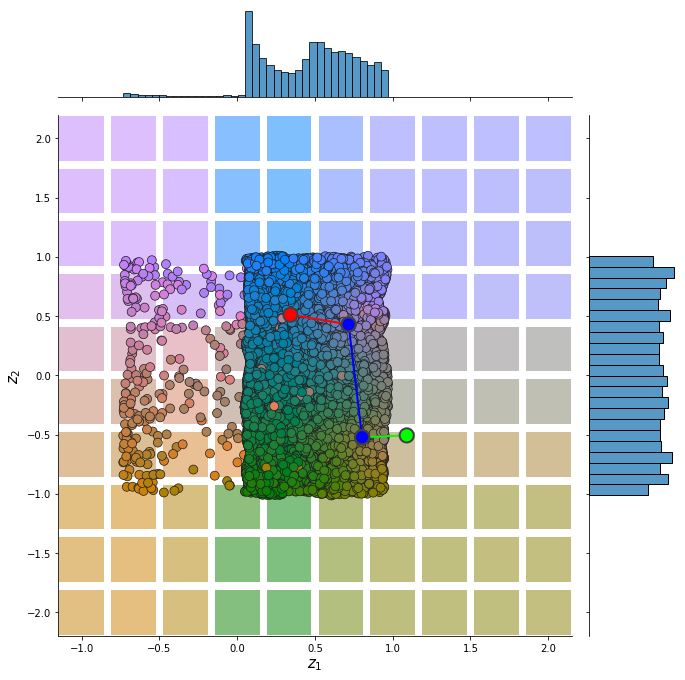

In [11]:
plot_representation(z.numpy(), index_colors=dataset.index_colors, z_extremes=z_extremes, interpolate_background=True, root=result_save_path)

### Input Reconstruction

In [12]:
from pdmtut.vis import plot_reconstruction

In [13]:
z = model.encode(dataset.X)
x = model.decode(z)

In [14]:
mse = (dataset.unnormalise_scale(dataset.X) - dataset.unnormalise_scale(x)).pow(2).sum(-1).mean()

if result_save_path is not None: 
    with open(os.path.join(result_save_path, 'reconstruction.txt'), 'w') as f:
        f.write(str(mse.item()))
        
mse

tensor(5.1534)

In [ ]:
plot_reconstruction(dataset.unnormalise_scale(x).numpy(), dataset.index_colors, root=result_save_path)

Scene(background_color='#ffffff', camera={'position': [-32.5, 0.0, 32.5], 'target': (0.0, 0.0, 0.0), 'up': (0.…

### Density Estimation

In [16]:
from pdmtut.vis import plot_density

In [17]:
log_likelihood = model.log_likelihood(dataset.X)

In [18]:
data_log_likelihood = log_likelihood.mean()

if result_save_path is not None: 
    with open(os.path.join(result_save_path, 'density.txt'), 'w') as f:
        f.write(str(data_log_likelihood.item()))
        
data_log_likelihood

tensor(1.)

In [19]:
plot_density(dataset.unnormalise_scale(dataset.X).numpy(), log_likelihood.numpy(), root=result_save_path)

AppLayout(children=(VBox(children=(HTML(value='<h3>Log probability</h3>'), Dropdown(description='Colormap:', o…

### Generate Samples

In [20]:
from pdmtut.vis import plot_generated_samples

In [21]:
generated_samples = model.sample_posterior(100**2)
generated_samples_log_likelihood = model.log_likelihood(generated_samples)

In [22]:
plot_generated_samples(dataset.unnormalise_scale(generated_samples).numpy(), generated_samples_log_likelihood.numpy(), root=result_save_path)

AppLayout(children=(VBox(children=(HTML(value='<h3>Log probability</h3>'), Dropdown(description='Colormap:', o…

### Interpolation

In [23]:
from pdmtut.vis import plot_interpolation
from scipy.interpolate import interp1d

In [24]:
z_extremes = model.encode(dataset.y_extremes)
uniform_state, uniform_log_prob, _ = dataset.sample_points_uniformly(n_samples=100**2, seed=11)

linfit1 = interp1d([1,20], z_extremes[:2].numpy(), axis=0)
linfit2 = interp1d([1,20], z_extremes[2:].numpy(), axis=0)
linfit3 = interp1d([1,20], z_extremes[[1,2]].numpy(), axis=0)

interpolated_points_1 = model.decode(torch.Tensor(linfit1(np.arange(1,21))))
interpolated_points_2 = model.decode(torch.Tensor(linfit2(np.arange(1,21))))
interpolated_points_3 = model.decode(torch.Tensor(linfit3(np.arange(1,21))))

/home/bawaw/.conda/envs/pdm_tutorial/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [25]:
plot_interpolation(
    dataset.unnormalise_scale(interpolated_points_1).numpy(), 
    dataset.unnormalise_scale(interpolated_points_2).numpy(), 
    dataset.unnormalise_scale(interpolated_points_3).numpy(), 
    uniform_state.detach().view(100, 100, 3).permute(2, 0, 1).numpy(),
    uniform_log_prob.numpy(), root=result_save_path
)

AppLayout(children=(VBox(children=(HTML(value='<h3>Log probability</h3>'), Dropdown(description='Colormap:', o…

### Extra (data trajectory)

In [26]:
n_steps = 100

# forward
ds_z = DynamicalState(state=model.base_distribution[:,[0,2]])
X = model.forward(ds_z, t0=0, t1=1, steps=n_steps, include_trajectory=True)

# inverse
ds_x = X.clone(); 
ds_x.remove_key('trajectory')
Z = model.inverse(ds_x, t0=1, t1=0, steps=n_steps, include_trajectory=True)


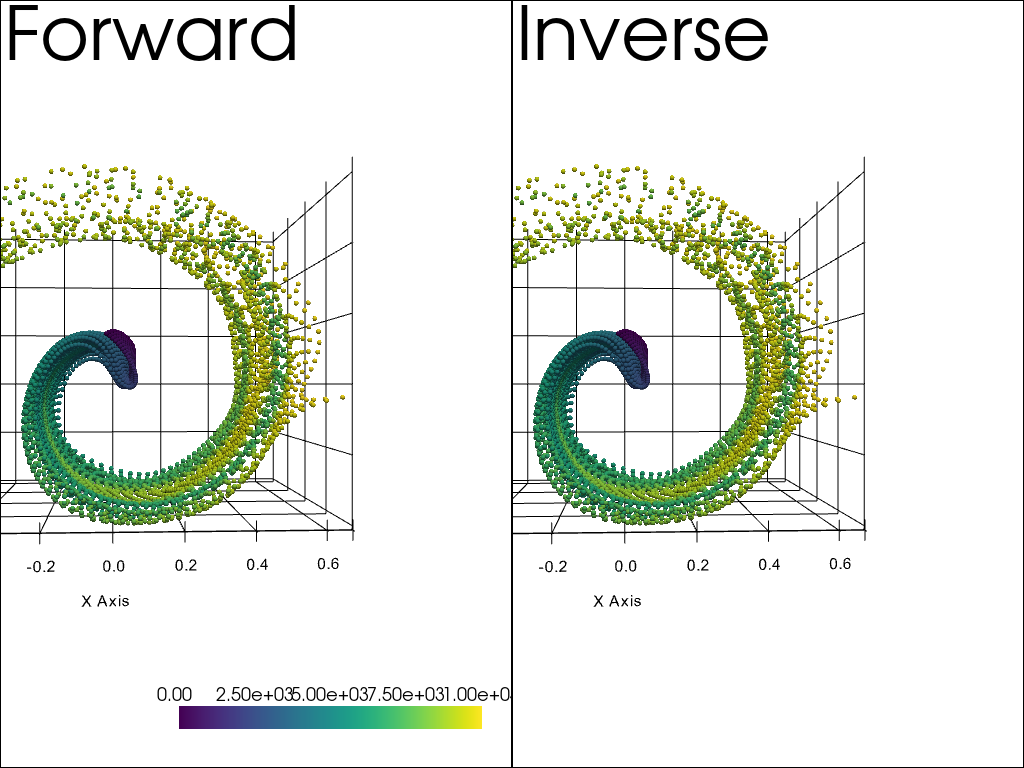

In [27]:
t=99

pv.set_plot_theme("document")
pv.set_jupyter_backend('None')

plotter = pv.Plotter(shape=(1, 2))

plotter.subplot(0, 0)
plotter.add_text("Forward", font_size=30)
plotter.add_mesh(pv.PolyData(X.trajectory[t].detach().numpy()), render_points_as_spheres=True, scalars=torch.arange(100**2), point_size=5)
plotter.camera_position = [(0, 0, 5), (0.5, 0, 0), (0, 1, 0)]
plotter.show_grid()


plotter.subplot(0, 1)
plotter.add_text("Inverse", font_size=30)
plotter.add_mesh(pv.PolyData(Z.trajectory[n_steps-(t+1)].detach().numpy()), render_points_as_spheres=True, scalars=torch.arange(100**2), point_size=5)
plotter.camera_position = [(0, 0, 5), (0.5, 0, 0), (0, 1, 0)]
plotter.show_grid()
plotter.show()

In [28]:
from regilib.vis.video_plotter import plot_video

# plot_video(
#     cp_X[:,0].detach(), 'lddmm_forward_cp.gif', render_points_as_spheres=True, reverse=False,
#     camera_pos = [(2, 0, 5), (0, 0, 0), (0, 1, 0)]    
# )

plot_video(
    X.trajectory.detach(), 'lddmm_forward.gif', render_points_as_spheres=True, reverse=False,
    camera_pos = [(0, 0, 5), (0, 0, 0), (0, 1, 0)]    
)

plot_video(
    Z.trajectory.detach(), 'lddmm_inverse.gif', render_points_as_spheres=True, reverse=False,
    camera_pos = [(0, 0, 5), (0, 0, 0), (0, 1, 0)]    
)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)